# Análisis de Utilización de Transcripciones
 
Este notebook carga un fichero CSV con líneas en el formato:
 
```
ep498_B_whisper_es.html,Héctor Socas,00:41:09.56
ep498_B_whisper_es.html,Francis Villatoro,00:48:40.78
ep498_B_whisper_es.html,Gastón Giribet,00:29:51.14
ep498_B_whisper_es.html,Isabel Cordero,00:01:43.82
```

y genera gráficas para visualizar la utilización de cada hablante.

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import math
import numpy as np


In [54]:
# 1. Cargar el CSV
SPFILE = '/home/jmrobles/Podcasts/Coffee Break/speakingtimes.csv'
df = pd.read_csv(SPFILE, header=None, names=['archivo', 'hablante', 'tiempo'])
df.head()

,archivo,hablante,tiempo
0,Fichero,Nombre,Tiempo
1,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Héctor Socas,00:20:49.13
2,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,José Ramón Arévalo,00:09:30.41
3,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Alfred Rosenberg,00:01:36.64
4,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Juan José Martín,00:05:20.34


In [55]:
# 2. Convertir la columna 'tiempo' a objetos timedelta
def convertir_a_timedelta(tiempo_str):
    try:
        tiempo_obj = datetime.strptime(tiempo_str, '%H:%M:%S.%f').time()
        return timedelta(hours=tiempo_obj.hour, minutes=tiempo_obj.minute, seconds=tiempo_obj.second, microseconds=tiempo_obj.microsecond)
    except ValueError:
        try:
            tiempo_obj = datetime.strptime(tiempo_str, '%M:%S.%f').time()
            return timedelta(minutes=tiempo_obj.minute, seconds=tiempo_obj.second, microseconds=tiempo_obj.microsecond)
        except ValueError:
            try:
                tiempo_obj = datetime.strptime(tiempo_str, '%S.%f').time()
                return timedelta(seconds=tiempo_obj.second, microseconds=tiempo_obj.microsecond)
            except ValueError:
                return timedelta(0)

df['tiempo_timedelta'] = df['tiempo'].apply(convertir_a_timedelta)
df = df[1:]
df.head()

,archivo,hablante,tiempo,tiempo_timedelta
1,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Héctor Socas,00:20:49.13,0 days 00:20:49.130000
2,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,José Ramón Arévalo,00:09:30.41,0 days 00:09:30.410000
3,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Alfred Rosenberg,00:01:36.64,0 days 00:01:36.640000
4,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Juan José Martín,00:05:20.34,0 days 00:05:20.340000
5,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Antonio Eff-Darwich,00:02:38.14,0 days 00:02:38.140000


In [56]:
# Incluir hablantes Unknown y ?? en la misma categoría
df['hablante'] = df['hablante'].apply(lambda x: 'Sin asignar' if str(x).startswith('???') or str(x).startswith('Unknown') else x)
df.head()

,archivo,hablante,tiempo,tiempo_timedelta
1,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Héctor Socas,00:20:49.13,0 days 00:20:49.130000
2,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,José Ramón Arévalo,00:09:30.41,0 days 00:09:30.410000
3,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Alfred Rosenberg,00:01:36.64,0 days 00:01:36.640000
4,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Juan José Martín,00:05:20.34,0 days 00:05:20.340000
5,/home/jmrobles/Podcasts/Coffee Break/Archivo/e...,Antonio Eff-Darwich,00:02:38.14,0 days 00:02:38.140000


In [57]:
# Agrupar por hablante y sumar los tiempos
totales_por_hablante = df.groupby('hablante')['tiempo_timedelta'].sum().reset_index()
totales_por_hablante['tiempo_segundos'] = totales_por_hablante['tiempo_timedelta'].dt.total_seconds()

# Cálculo de tiempo total y tiempo sin asignar
tiempo_total_acumulado_segundos = totales_por_hablante['tiempo_segundos'].sum()
sin_asignar_segundos = totales_por_hablante.loc[totales_por_hablante['hablante'] == 'Sin asignar', 'tiempo_segundos'].sum()

print(f'Tiempo total acumulado: {tiempo_total_acumulado_segundos} segundos')
print(f'Tiempo sin asignar: {sin_asignar_segundos} segundos')



Tiempo total acumulado: 4486048.109999999 segundos
Tiempo sin asignar: 40255.51 segundos


In [58]:
# Eliminar la categoría 'Sin asignar' para el gráfico
totales_por_hablante_reconocido = totales_por_hablante[totales_por_hablante['hablante'] != 'Sin asignar']

num_hablantes = len(totales_por_hablante_reconocido)

# Ordenar por tiempo total
totales_por_hablante_reconocido = totales_por_hablante_reconocido.sort_values('tiempo_segundos', ascending=False)
print (f"Núéro de hablantes reconocido: {num_hablantes}")


Núéro de hablantes reconocido: 163


In [59]:
def segundos_a_hhmmss(segundos):
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segundos = int(segundos % 60)
    return f'{horas:02d}:{minutos:02d}:{segundos:02d}'
print(segundos_a_hhmmss(65458))

18:10:58


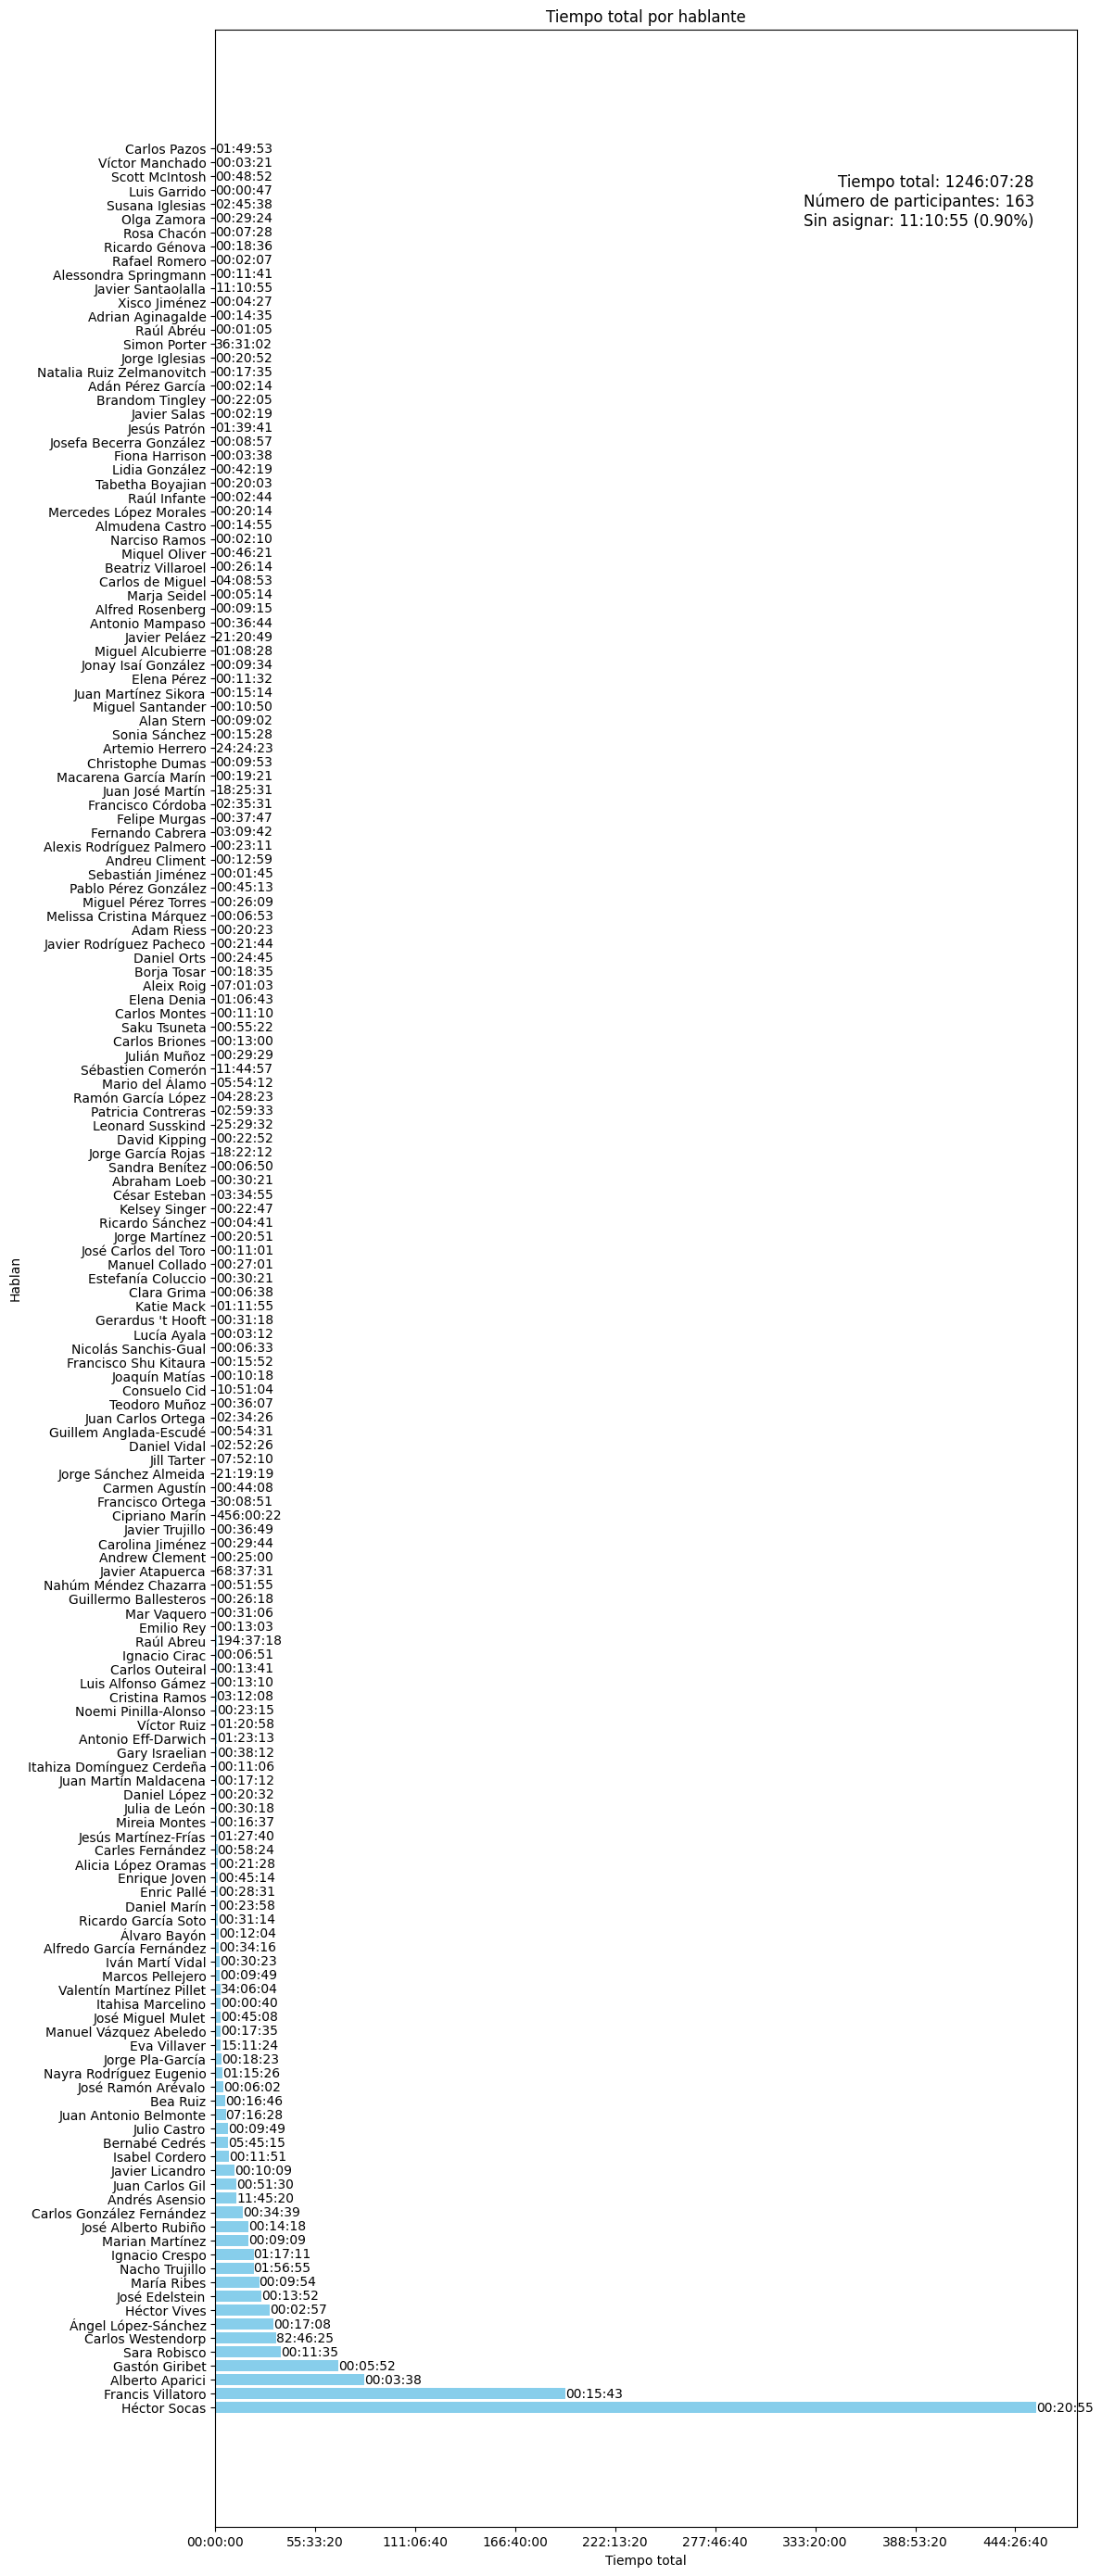

In [60]:
# Crear el gráfico de barras horizontales
plt.figure(figsize=(12, 35))
bars = plt.barh(totales_por_hablante_reconocido['hablante'], totales_por_hablante_reconocido['tiempo_segundos'], color='skyblue')

# Formatear el eje x para mostrar el tiempo en formato legible


plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: segundos_a_hhmmss(x)))

# Añadir etiquetas y título
plt.xlabel('Tiempo total')
plt.ylabel('Hablan')
plt.title('Tiempo total por hablante')

# Mostrar los valores de tiempo a la derecha de las barras
for bar, segundos in zip(bars, totales_por_hablante['tiempo_segundos']):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height() / 2, segundos_a_hhmmss(segundos), va='center')

# Calcular el tiempo total acumulado y el tiempo sin asignar en formato hh:mm:ss
tiempo_total_acumulado_hhmmss = segundos_a_hhmmss(tiempo_total_acumulado_segundos)
sin_asignar_hhmmss = segundos_a_hhmmss(sin_asignar_segundos)

# Añadir anotación con el tiempo total acumulado y el tiempo sin asignar
plt.text(0.95, 0.95, f'''
Tiempo total: {tiempo_total_acumulado_hhmmss}
Número de participantes: {num_hablantes}
Sin asignar: {sin_asignar_hhmmss} ({sin_asignar_segundos/tiempo_total_acumulado_segundos*100:.2f}%)
''', color='black', fontsize=12,
         transform=plt.gca().transAxes, ha='right', va='top')

# 13. Mostrar el gráfico y guardarlo en un archivo
# plt.show()
plt.savefig('speakingtime.png')
plt.show()
plt.close()

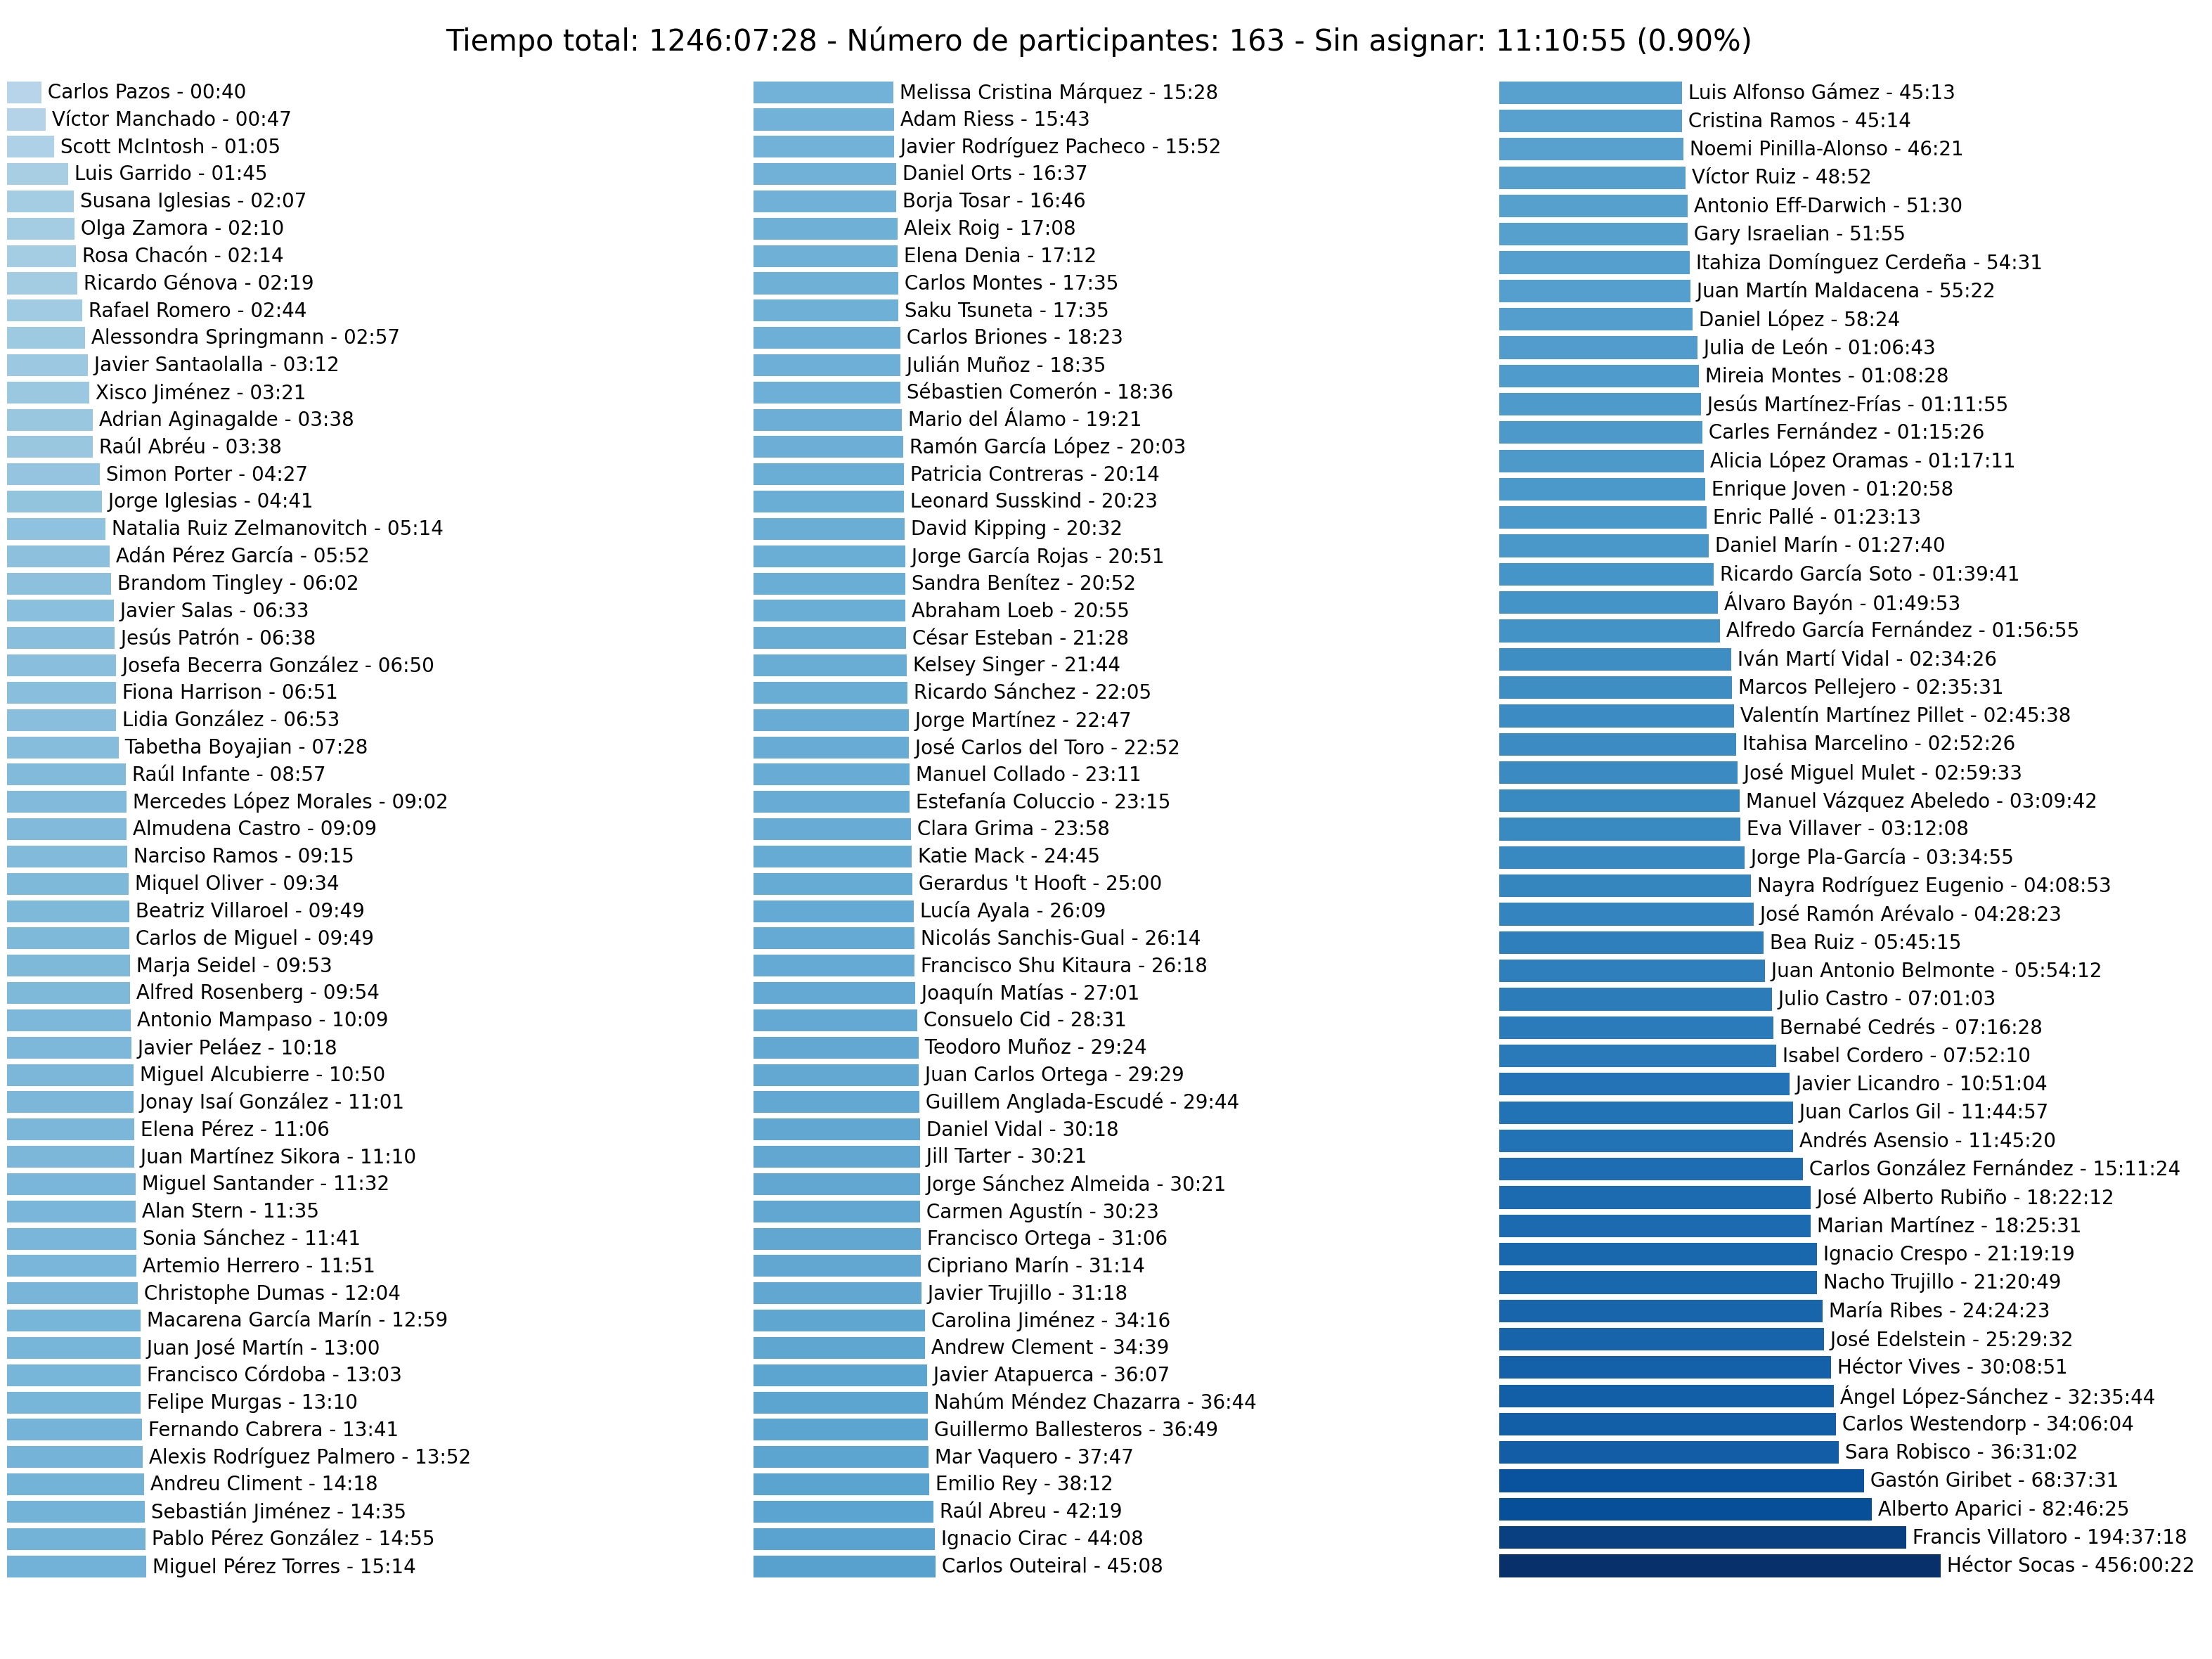

In [84]:

import matplotlib.colors as mcolors

# Define el número de subplots que deseas
n_subplots = 3  # Puedes ajustar este valor según necesites

# Ordenar el DataFrame por tiempo de participación (de menor a mayor)
totales_ordenados = totales_por_hablante_reconocido.sort_values('tiempo_segundos')

# Calculamos cuántos hablantes van en cada subplot
total_hablantes = len(totales_ordenados)
hablantes_por_subplot = math.ceil(total_hablantes / n_subplots)

# Definir la función para convertir segundos a formato mm:ss o hh:mm:ss
def segundos_a_formato_legible(segundos):
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segundos_rest = int(segundos % 60)
    
    if horas > 0:
        return f'{horas:02d}:{minutos:02d}:{segundos_rest:02d}'
    else:
        return f'{minutos:02d}:{segundos_rest:02d}'

# Crear paleta de colores degradados según el tiempo de participación
tiempo_min = totales_ordenados['tiempo_segundos'].min()
tiempo_max = totales_ordenados['tiempo_segundos'].max()

def val_to_plot(x):
    return np.log1p(x/30)
    
def obtener_color(tiempo):
    # Normalizar el tiempo entre 0 y 1
    normalizado = (val_to_plot(tiempo) - val_to_plot(tiempo_min)) / (val_to_plot(tiempo_max) - val_to_plot(tiempo_min))
    # Usar un mapa de colores que va de azul claro a azul oscuro
    return plt.cm.Blues(0.3 + normalizado * 0.7)

# Crear la figura con subplots horizontales (1 fila, n columnas)
fig, axs = plt.subplots(1, n_subplots, figsize=(32, 24))
fig.tight_layout()
if n_subplots == 1:  # Si solo hay un subplot, convertir axs a lista para mantener consistencia
    axs = [axs]

# Crear tres gráficos separados con tamaños optimizados para cada grupo
for i in range(n_subplots):
    # Calcular índices de inicio y fin para este subplot
    inicio = i * hablantes_por_subplot
    fin = min((i + 1) * hablantes_por_subplot, total_hablantes)
    
    # Verificar si hay datos para este subplot
    if inicio >= total_hablantes:
        continue
    
    # Obtener datos para este subplot
    subset = totales_ordenados.iloc[inicio:fin].copy()
    num_hablantes_subplot = len(subset)
    
    # Ordenar descendente para que los que más hablan estén arriba (mejor visibilidad)
    subset = subset.sort_values('tiempo_segundos', ascending=False)
   
    # Usamos escala logarítmica para visualizar mejor las diferencias
    tiempos_log = val_to_plot(subset['tiempo_segundos'])
    
    # # Calcular altura óptima basada en número de hablantes (más espacio por hablante)
    # altura_optima = max(8, num_hablantes_subplot * 0.35)
    
    # # Crear figura con tamaño optimizado
    # plt.figure(figsize=(12, altura_optima))
    
    # Asignar colores basados en el tiempo
    colores = [obtener_color(t) for t in subset['tiempo_segundos']]
    
    # Crear barras horizontales con colores personalizados
    bars = axs[i].barh(subset['hablante'], tiempos_log, color=colores)
    
    # Quitar ticks del eje x (escala logarítmica no es informativa directamente)
    axs[i].set_xticks([])
    
    # Mostrar los valores de tiempo a la derecha de las barras
    for bar, segundos, nombre in zip(bars, subset['tiempo_segundos'], subset['hablante']):
        # Calcular posición para el texto
        tiempo_texto = segundos_a_formato_legible(segundos)
        axs[i].text(bar.get_width() , bar.get_y() + bar.get_height()/2, 
                f' {nombre} - {tiempo_texto}', va='center', fontsize=20)
    
    # Quitar el eje y ya que ponemos los nombres en las etiquetas
    axs[i].set_yticks([])
    axs[i].axis('off')
    
    # # Eliminar bordes del gráfico
    # plt.box(False)
    
    # Título del grupo
    # tiempo_min_grupo = subset['tiempo_segundos'].min()
    # tiempo_max_grupo = subset['tiempo_segundos'].max()
    # axs[i].set_title(f'Grupo {i+1}: {segundos_a_formato_legible(tiempo_min_grupo)} - {segundos_a_formato_legible(tiempo_max_grupo)}',
    #           fontsize=14, pad=20)

    # Establecer la misma escala para todos los gráficos
    axs[i].set_xlim(0, val_to_plot(tiempo_maximo) * 1.6)  # 60% extra para acomodar etiquetas
    # Ajustar márgenes
    # plt.tight_layout()
    # plt.show()
    
    # Guardar cada gráfico por separado
    # plt.savefig(f'tiempo_hablantes_grupo_{i+1}.png', bbox_inches='tight', dpi=300)
    # plt.close()

# # Crear un gráfico adicional con información de resumen
# plt.figure(figsize=(10, 5))
# plt.axis('off')
# plt.text(0.5, 0.6, f'''RESUMEN DE PARTICIPACIÓN
# Tiempo total: {segundos_a_formato_legible(tiempo_total_acumulado_segundos)}
# Número de participantes: {num_hablantes}
# Sin asignar: {segundos_a_formato_legible(sin_asignar_segundos)} ({sin_asignar_segundos/tiempo_total_acumulado_segundos*100:.2f}%)
# ''', 
#          fontsize=16, ha='center', va='center')
# plt.tight_layout()
plt.suptitle(f'Tiempo total: {segundos_a_formato_legible(tiempo_total_acumulado_segundos)} - Número de participantes: {num_hablantes} - Sin asignar: {segundos_a_formato_legible(sin_asignar_segundos)} ({sin_asignar_segundos/tiempo_total_acumulado_segundos*100:.2f}%)',
             fontsize=30)

plt.savefig("speaking_times.png")
plt.show()
plt.close()